# Autoencoders

<a target="_blank" href="https://colab.research.google.com/github/GaiaSaveri/intro-to-ml/blob/main/solved-notebooks/SOLVED-Lab-13.Autoencoders.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

An autoencoder is a type of neural network architecture that finds the function mapping the features $x$ to itself. This objective is known as reconstruction, and is accomplished through an encoder and a decoder:
* the encoder compresses the input data into a lower-dimensional representation that captures the most important features or patterns;
* the decoder reconstructs the original data from the compressed representation.

The compressed representation learned by an autoencoder can be visualized as a lower-dimensional space, where similar inputs are mapped to nearby points and dissimilar inputs are mapped to distant points. This makes autoencoders useful for tasks such as dimensionality reduction, anomaly detection, and generative modeling.

**NOTE:** *If linear activations are used, or only a single sigmoid hidden layer, then the optimal solution to an autoencoder is strongly related to principal component analysis (PCA). However, the potential of autoencoders resides in their non-linearity, allowing the model to learn more powerful generalizations compared to PCA, and to reconstruct the input with significantly lower information loss.*

Gli autoencoder sono una classe di reti neurali utilizzate nel machine learning, in particolare nell'apprendimento non supervisionato, per l'apprendimento di rappresentazioni efficienti dei dati di input. Sono costituiti da due parti principali: un encoder e un decoder.

L'obiettivo di un autoencoder è imparare a comprimere i dati di input in una rappresentazione a bassa dimensionalità (codifica) e successivamente a ricostruire l'input originale il più fedelmente possibile a partire da questa codifica. Le applicazioni degli autoencoder includono la riduzione della dimensionalità, l'estrazione di caratteristiche, la denoising (rimozione del rumore) e la generazione di nuovi campioni simili ai dati di addestramento.

Ecco una spiegazione più dettagliata delle componenti di un autoencoder:

- Encoder: L'encoder è una rete neurale che prende in input i dati e li trasforma in una rappresentazione a bassa dimensionalità, chiamata codifica o codice latente. Questo processo di riduzione della dimensionalità permette di catturare le caratteristiche più importanti dei dati, comprimendo le informazioni in una forma più compatta.

- Decoder: Il decoder è un'altra rete neurale che prende la codifica prodotta dall'encoder e cerca di ricostruire i dati di input originari. Il decoder può essere visto come il processo inverso dell'encoder, in quanto mappa la rappresentazione a bassa dimensionalità nella dimensionalità originale dei dati di input.

Durante la fase di addestramento, un autoencoder cerca di minimizzare la differenza tra i dati di input e la loro ricostruzione prodotta dal decoder. Questa differenza è chiamata funzione obiettivo o funzione di perdita e misura la qualità della rappresentazione appresa. Un autoencoder ben addestrato sarà in grado di comprimere e ricostruire accuratamente i dati di input, pur mantenendo una rappresentazione a bassa dimensionalità.

Esistono diverse varianti di autoencoder, tra cui gli autoencoder a strati convolutivi (convolutional autoencoders) per lavorare con immagini, gli autoencoder ricorrenti (recurrent autoencoders) per sequenze temporali e gli autoencoder variazionali (variational autoencoders), che introducono un modello probabilistico per la codifica latente, permettendo la generazione di nuovi campioni.

In [1]:
# import all needed packages 
import torch
import torch.nn as nn
import torch.utils.data as data
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from time import time
import random

# reproducibility
torch.manual_seed(1)
np.random.seed(2)
random.seed(3)

In [3]:
# Set arguments
batch_size = 128

# DataLoader Train
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True,
    transform=torchvision.transforms.ToTensor())

trainloader = data.DataLoader(trainset, batch_size=batch_size, shuffle=True)


# DataLoader Test
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True,
    transform=torchvision.transforms.ToTensor())

testloader = data.DataLoader(testset, batch_size=16, shuffle=False)

100%|██████████| 9912422/9912422 [00:01<00:00, 9111572.00it/s] 


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 14467418.35it/s]

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 6969430.56it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 4542/4542 [00:00<00:00, 4547750.96it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



## Training

##### **1. Define the model architecture of an AutoEncoder** 
 As mentioned, it is divided in two parts: encoder and decoder.  
  - The encoder takes as input a flattened image of size $28x28$ and applies a series of fully connected layers with Tanh activation function. The output of its last layer has dimension $2$.   
  - The decoder takes the 2-dimensional encoded representation and applies a series of fully connected layers with Tanh activation function in the reverse order. The last layer applies a sigmoid activation function to map the reconstructed output to the range $[0,1]$.

In [4]:
# Model structure
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),

            # hyperbolic tangent activation function, often used in hidden layers because it produces outputs in the range [-1,1], 
            # which helps to prevent saturation of the weights during training.
            nn.Tanh(), 

            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 16),
            nn.Tanh(),
            nn.Linear(16, 2),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, 16),
            nn.Tanh(),
            nn.Linear(16, 64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, 28*28),
            
            # map the reconstructed output to [0,1]
            nn.Sigmoid() 
        )

    def forward(self, x):
        codes = self.encoder(x)
        decoded = self.decoder(codes)

        return codes, decoded

In [7]:
def train_model(model, num_epochs, trainloader, criterion, optimizer):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model = model.to(device)

    losses = []
   
    for epoch in range(num_epochs):
        train_running_loss = 0.0

        # Set the model to training mode
        model = model.train()
        start = time()
        ## training step
        for i, (images, labels) in enumerate(trainloader):
            
            # difference here! Similar to .flatten()
            images = images.view(-1, 28*28)

            images = images.to(device)
            labels = labels.to(device)

            ## forward + backprop + loss
            codes, decoded = model(images)
            loss = criterion(decoded, images)

            # Reset the gradients to zero
            optimizer.zero_grad()

            loss.backward()

            ## update model params
            optimizer.step()

            train_running_loss += loss.item()
        
            
        losses.append(train_running_loss / i)
        
        model.eval()
        print(f"Epoch: {epoch+1} | Loss: {train_running_loss / i:.4f} | Time: {time()-start:.2f}") 
    
    return losses

non esiste l'accuracy in questo caso perchè non è un problema di classificazione.

For image data with AutoEncoders it is common to use the mean squared error (MSE) loss function, as it measures the difference between the input image pixels and the reconstructed ones. We are not concerned with labels in this case.

In [8]:
# Optimizer and loss function
model = AutoEncoder()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [9]:
L = train_model(model, 15, trainloader, criterion, optimizer)

Epoch: 1 | Loss: 0.0701 | Time: 10.52
Epoch: 2 | Loss: 0.0580 | Time: 8.56
Epoch: 3 | Loss: 0.0545 | Time: 8.38
Epoch: 4 | Loss: 0.0522 | Time: 8.37
Epoch: 5 | Loss: 0.0504 | Time: 8.41
Epoch: 6 | Loss: 0.0493 | Time: 8.43
Epoch: 7 | Loss: 0.0485 | Time: 8.40
Epoch: 8 | Loss: 0.0479 | Time: 8.42
Epoch: 9 | Loss: 0.0475 | Time: 8.50
Epoch: 10 | Loss: 0.0465 | Time: 8.30
Epoch: 11 | Loss: 0.0454 | Time: 8.24
Epoch: 12 | Loss: 0.0445 | Time: 8.23
Epoch: 13 | Loss: 0.0440 | Time: 8.28
Epoch: 14 | Loss: 0.0435 | Time: 8.23
Epoch: 15 | Loss: 0.0430 | Time: 8.40


## Test effects
Now that we have trained the AutoEncoder model, let’s take a look at the picture we restored from the compression. Does it look like the original picture?

In [10]:
# Show images function
def show_images(images):
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))

    for index, image in enumerate(images):
        plt.subplot(sqrtn, sqrtn, index+1)
        plt.imshow(image.reshape(28, 28), cmap='gray')
        plt.axis('off')

Originals


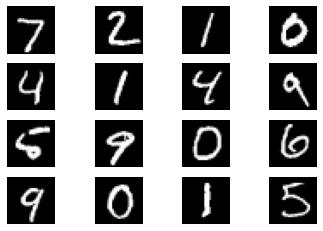

Produced by AutoEncoder


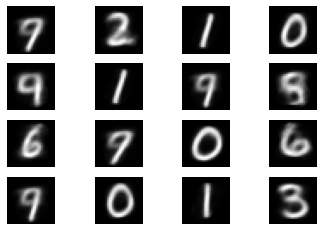

In [11]:
model.eval()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Test
with torch.no_grad():
    for images, _ in testloader:
        print("Originals")
        inputs = images.view(-1, 28*28)
        show_images(inputs)
        plt.show()

        print("Produced by AutoEncoder")
        inputs = inputs.to(device)
        code, outputs = model(inputs)
        show_images(outputs.cpu())
        plt.show()
        break

Sopra ci sono le immagini originali del test set, sotto quelle ricostruite dall'autoencoder.

## Visualise compressed data
Earlier, we set the dimension of the output of the encoder to $2$. These two values can be thought of as the $x$ and $y$ coordinates of a point in a two-dimensional space that represents a compressed version of the input image.  
Let's generate a scatter plot of these encoded representations of the images in the test set.


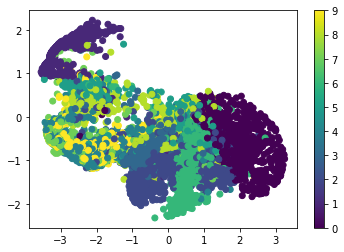

In [12]:
axis_x = []
axis_y = []
answers = []

# turn off gradient calculation to speed up the process
with torch.no_grad():
    for images, labels in testloader:
        inputs = images.view(-1, 28*28)
        answers += labels.tolist()

        inputs = inputs.to(device)
        code, outputs = model(inputs)
        code = code.cpu()
        axis_x += code[:, 0].tolist()
        axis_y += code[:, 1].tolist()


plt.scatter(axis_x, axis_y, c=answers)
plt.colorbar()
plt.show()

Tutti i punti vengono mappati in un punto del piano (come PCa come concetto), ma qui punti simili vengono mappaati in punti vicini, e punti diversi in punti lontani. Questo è un vantaggio rispetto a PCA, che non tiene conto della struttura dei dati.

The data compressed by the Autoencoder has been able to grasp the existence of different features in each number.

## One step further: different types of Autoencoders

There are several types of autoencoders, each designed for a specific purpose. Here are some of the most common types:

* **Convolutional autoencoder**: This type of autoencoder is specifically designed for image data. It uses convolutional layers in the encoder and decoder to take advantage of the spatial structure in the data.
* **Recurrent autoencoder**: This type of autoencoder is designed for sequential data, such as time series or text. It uses recurrent neural networks (RNNs) in the encoder and decoder to capture the temporal dependencies in the data.
* **Denoising autoencoder**: This type of autoencoder is designed to remove noise from input data. During training, the model is fed noisy input data and is trained to reconstruct the original, noise-free input.
* **Variational autoencoder** (VAE): This type of autoencoder is designed to generate new data samples that are similar to the original input data. It uses a probabilistic approach to generate data by sampling from a learned distribution.

##### **2. Create a convolutional autoencoder and use it on MNIST. See how the reconstructed images change and how the encoded representations are scattered in a plane.**

Its decoder uses transposed convolutional layers to increase the width and height of the input layers. They work almost exactly the same as convolutional layers, but in reverse. A stride in the input layer results in a larger stride in the transposed convolution layer. For example, if you have a $3x3$ kernel, a $3x3$ patch in the input layer will be reduced to one unit in a convolutional layer. Comparatively, one unit in the input layer will be expanded to a $3x3$ path in a transposed convolution layer. PyTorch provides us with an easy way to create these layers, [`nn.ConvTranspose2d`](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html).

In [13]:
# Model structure
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super(ConvAutoEncoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            
            # stride specifies what is the distance between consecutive applications of convolutional filters
            # stride >= 2 -> downsample the input and extract higher-level features
            # padding applies a 1 pixel padding on all sides of the image just before computing the convolution operation
            # More on this: https://d2l.ai/chapter_convolutional-neural-networks/padding-and-strides.html
            # non riceve piu come input un vettore, ma un'immagine
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1), # prendo stride 2 perche voglio fare downsampling

            nn.Tanh(), 
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.Tanh(),
            nn.Conv2d(32, 2, kernel_size=7)
        )

        # Decoder, qui devi usare ConvTranspose2d (l'opposto di Conv2d)
        self.decoder = nn.Sequential(
            # ma devi stare attento a come imposti i parametri
            nn.ConvTranspose2d(2, 32, kernel_size=7),
            nn.Tanh(),

            # output padding is only used to find output shape, but does not actually add zero-padding to output
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            
            nn.Sigmoid() 
        )

    def forward(self, x):
        codes = self.encoder(x)
        decoded = self.decoder(codes)

        return codes, decoded

comunque raramente dovrai modificare stride e padding, perchè sono già ottimizzati per le immagini.

Since this is a convlutional autoencoder, our images do not need to be flattened before being passed in an input to our model. Therefore, we need to change our training function.

In [14]:
def train_convmodel(model, num_epochs, trainloader, criterion, optimizer):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    model = model.to(device)

    losses = []
   
    for epoch in range(num_epochs):
        train_running_loss = 0.0

        # Set the model to training mode
        model = model.train()
        start = time()
        ## training step
        for i, (images, labels) in enumerate(trainloader):
            

            # removed view for convolutions! 


            images = images.to(device)
            labels = labels.to(device)

            ## forward + backprop + loss
            codes, decoded = model(images)
            loss = criterion(decoded, images)

            # Reset the gradients to zero
            optimizer.zero_grad()

            loss.backward()

            ## update model params
            optimizer.step()

            train_running_loss += loss.item()
        
            
        losses.append(train_running_loss / i)
        
        model.eval()
        print(f"Epoch: {epoch+1} | Loss: {train_running_loss / i:.4f} | Time: {time()-start:.2f}") 
    
    return losses

In [15]:
# Optimizer and loss function
model = ConvAutoEncoder()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [17]:
L = train_convmodel(model, 15, trainloader, criterion, optimizer)

Epoch: 1 | Loss: 0.0471 | Time: 10.33
Epoch: 2 | Loss: 0.0470 | Time: 10.13
Epoch: 3 | Loss: 0.0469 | Time: 10.39
Epoch: 4 | Loss: 0.0467 | Time: 10.16
Epoch: 5 | Loss: 0.0465 | Time: 10.29
Epoch: 6 | Loss: 0.0466 | Time: 10.19
Epoch: 7 | Loss: 0.0464 | Time: 10.26
Epoch: 8 | Loss: 0.0463 | Time: 10.28
Epoch: 9 | Loss: 0.0464 | Time: 10.12
Epoch: 10 | Loss: 0.0463 | Time: 9.79
Epoch: 11 | Loss: 0.0461 | Time: 9.80
Epoch: 12 | Loss: 0.0461 | Time: 9.63
Epoch: 13 | Loss: 0.0461 | Time: 9.72
Epoch: 14 | Loss: 0.0460 | Time: 9.85
Epoch: 15 | Loss: 0.0460 | Time: 9.79


Originals


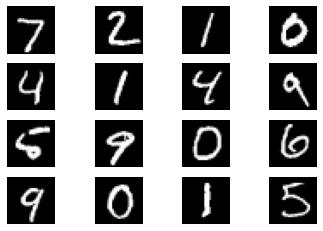

Produced by ConvAutoEncoder


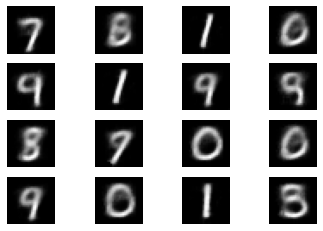

In [18]:
model.eval()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Test
with torch.no_grad():
    for inputs, _ in testloader:
        print("Originals")
        show_images(inputs)
        plt.show()

        print("Produced by ConvAutoEncoder")
        inputs = inputs.to(device)
        code, outputs = model(inputs)
        show_images(outputs.cpu())
        plt.show()
        break

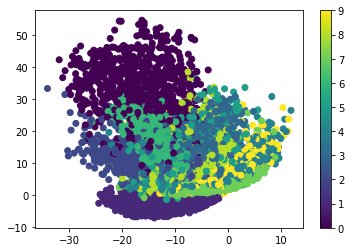

In [19]:
axis_x = []
axis_y = []
answers = []

# turn off gradient calculation to speed up the process
with torch.no_grad():
    for inputs, labels in testloader:
        answers += labels.tolist()

        inputs = inputs.to(device)
        code, outputs = model(inputs)
        code = code.cpu()
        axis_x += code[:, 0].tolist()
        axis_y += code[:, 1].tolist()


plt.scatter(axis_x, axis_y, c=answers)
plt.colorbar()
plt.show()